In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import pymc3 as pm
import arviz as az

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Normal likelihood, unknown mean and variance

The model is:

$ 
\begin{align}
y_i \mid \mu, \sigma^2 &\overset{\text{iid}}{\sim} \text{N} ( \mu, \sigma^2 ), \quad i=1,\ldots,n \\ 
\mu &\sim \text{N}(\mu_0, \sigma_0^2) \\ 
\sigma^2 &\sim \text{IG}(\nu_0, \beta_0)  \, .
\end{align} 
$

We chose a normal prior for $μ$ because, in the case where $σ^2$ is known, the normal is the conjugate prior for $μ$. Likewise, in the case where $μ$ is known, the inverse-gamma is the conjugate prior for $σ^2$. This will give us convenient full conditional distributions in a Gibbs sampler.

Let’s first work out the form of the full posterior distribution.

$ 
\begin{align}
p( \mu, \sigma^2 \mid y_1, y_2, \ldots, y_n ) &\propto
p(y_1, y_2, \ldots, y_n \mid \mu, \sigma^2) p(\mu) p(\sigma^2) \\ 
&= \prod_{i=1}^n \text{N} ( y_i \mid \mu, \sigma^2 ) \times \text{N}( \mu \mid \mu_0, \sigma_0^2) \times \text{IG}(\sigma^2 \mid \nu_0, \beta_0) \\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}\exp \left[ -\frac{(y_i - \mu)^2}{2\sigma^2} \right] \times \frac{1}{\sqrt{2\pi\sigma_0^2}} \exp \left[ -\frac{(\mu - \mu_0)^2}{2\sigma_0^2} \right] \times \frac{\beta_0^{\nu_0}}{\Gamma(\nu_0)}(\sigma^2)^{-(\nu_0 + 1)} \exp \left[ -\frac{\beta_0}{\sigma^2} \right] I_{\sigma^2 > 0}(\sigma^2) \\
&\propto (\sigma^2)^{-n/2} \exp \left[ -\frac{\sum_{i=1}^n (y_i - \mu)^2}{2\sigma^2} \right] \exp \left[ -\frac{(\mu - \mu_0)^2}{2\sigma_0^2} \right] (\sigma^2)^{-(\nu_0 + 1)} \exp \left[ -\frac{\beta_0}{\sigma^2} \right] I_{\sigma^2 > 0}(\sigma^2)
\end{align}
$

From here, it is easy to continue on to find the two full conditional distributions we need. First let’s look at $μ$, assuming $σ2$ is known (in which case it becomes a constant and is absorbed into the normalizing constant):

$
\begin{align}
p(\mu \mid \sigma^2, y_1, \ldots, y_n) &\propto p( \mu, \sigma^2 \mid y_1, \ldots, y_n ) \\
&\propto \exp \left[ -\frac{\sum_{i=1}^n (y_i - \mu)^2}{2\sigma^2} \right] \exp \left[ -\frac{(\mu - \mu_0)^2}{2\sigma_0^2} \right] \\
&\propto \exp \left[ -\frac{1}{2} \left( \frac{ \sum_{i=1}^n (y_i - \mu)^2}{2\sigma^2} + \frac{(\mu - \mu_0)^2}{2\sigma_0^2} \right) \right] \\
&\propto \text{N} \left( \mu \mid \frac{n\bar{y}/\sigma^2 + \mu_0/\sigma_0^2}{n/\sigma^2 + 1/\sigma_0^2}, \, \frac{1}{n/\sigma^2 + 1/\sigma_0^2} \right) \, ,
\end {align}
$

Given the data and $σ^2$, $μ$ follows this normal distribution. Now let’s look at $σ^2$, assuming $μ$ is known: 

$ 
\begin{align}
p(\sigma^2 \mid \mu, y_1, \ldots, y_n) &\propto p( \mu, \sigma^2 \mid y_1, \ldots, y_n ) \\
&\propto (\sigma^2)^{-n/2} \exp \left[ -\frac{\sum_{i=1}^n (y_i - \mu)^2}{2\sigma^2} \right] (\sigma^2)^{-(\nu_0 + 1)} \exp \left[ -\frac{\beta_0}{\sigma^2} \right] I_{\sigma^2 > 0}(\sigma^2) \\
&\propto (\sigma^2)^{-(\nu_0 + n/2 + 1)} \exp \left[ -\frac{1}{\sigma^2} \left( \beta_0 + \frac{\sum_{i=1}^n (y_i - \mu)^2}{2} \right) \right] I_{\sigma^2 > 0}(\sigma^2) \\
&\propto \text{IG}\left( \sigma^2 \mid \nu_0 + \frac{n}{2}, \, \beta_0 + \frac{\sum_{i=1}^n (y_i - \mu)^2}{2} \right) \, .
\end{align}
$

These two distributions provide the basis of a Gibbs sampler to simulate from a Markov chain whose stationary distribution is the full posterior of both $μ$ and $σ^2$. We simply alternate draws between these two parameters, using the most recent draw of one parameter to update the other.


To implement the Gibbs sampler we just described, let’s return to our running example where the data are the percent change in total personnel from last year to this year for $n=10$ companies. We’ll still use a normal likelihood, but now we’ll relax the assumption that we know the variance of growth between companies, $σ^2$, and estimate that variance. Instead of the $t$ prior from earlier, we will use the conditionally conjugate priors, normal for $μ$ and inverse-gamma for $σ^2$.

The first step will be to write functions to simulate from the full conditional distributions we derived in the previous segment. The full conditional for $μ$, given $σ^2$ and data is:

$ \text{N} \left( \mu \mid \frac{n\bar{y}/\sigma^2 + \mu_0/\sigma_0^2}{n/\sigma^2 + 1/\sigma_0^2}, \, \frac{1}{n/\sigma^2 + 1/\sigma_0^2} \right) $

In [2]:
from scipy.stats import norm

def update_mu(n, y_bar, sig2, mu_0, sig2_0):
    sig2_1 = 1.0 / (n / sig2 + 1.0 / sig2_0)
    mu_1 = sig2_1 * ((n * y_bar / sig2) + (mu_0 / sig2_0))
    mu_cand = norm.rvs(size=1, loc = mu_1, scale = np.sqrt(sig2_1))[0] # draw a candidate
    return mu_cand

The full conditional for $σ^2$ given $μ$ and data is: 

$ \text{IG}\left( \sigma^2 \mid \nu_0 + \frac{n}{2}, \, \beta_0 + \frac{\sum_{i=1}^n (y_i - \mu)^2}{2} \right) $

In [3]:
from scipy.stats import gamma

def update_sig2(n, y, mu, nu_0, beta_0):
    nu_1 = nu_0 + (n / 2.0)
    sumsq = np.sum( (y - mu)**2 ) # vectorized
    beta_1 = beta_0 + sumsq / 2.0
    rv = gamma(nu_1, loc = 0., scale = 1/beta_1)
    out_gamma = rv.rvs(size = 1)[0] # rate for gamma is shape for inv-gamma
    return 1 / out_gamma # reciprocal of a gamma random variable is distributed inv-gamma

With functions for drawing from the full conditionals, we are ready to write a function to perform Gibbs sampling.

In [4]:
def gibbs(y, n_iter, init, prior):
    y_bar = np.mean(y)
    n = y.shape[0]

    ## initialize
    mu_out = []
    sig2_out = []

    mu_now = init

    for i in range(n_iter):
        sig2_now = update_sig2(n = n, y = y, mu = mu_now, nu_0 = prior['nu_0'], beta_0 = prior['beta_0'])
        mu_now = update_mu(n = n, y_bar = y_bar, sig2 = sig2_now, mu_0 = prior['mu_0'], sig2_0 = prior['sig2_0'])

        sig2_out.append(sig2_now)
        mu_out.append(mu_now)

    return mu_out, sig2_out

Setting up the problem

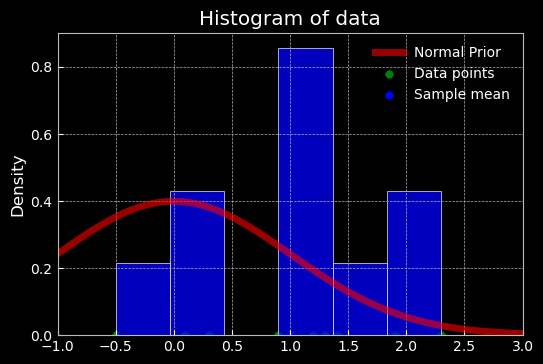

In [5]:
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9]) # Data
y_bar = np.mean(y) # Sample mean
n = y.shape[0] # Data points

## Prior
prior = {}
prior['mu_0'] = 0.0
prior['sig2_0'] = 1.0
prior['n_0'] = 2.0 # prior effective sample size for sig2 (2 samples)
prior['s2_0'] = 1.0 # prior point estimate for sig2
prior['nu_0'] = prior['n_0'] / 2.0 # prior parameter for inverse-gamma
prior['beta_0'] = prior['n_0'] * prior['s2_0'] / 2.0 # prior parameter for inverse-gamma

# Plotting the histogram of the random samples
fig, ax = plt.subplots(1, 1)
sns.histplot(np.array(y), stat= 'density', bins = 6)
# Sampling in all the domain of the function
ax.plot(np.linspace(-2, 4, 100), norm.pdf(x = np.linspace(-2, 4, 100), loc = prior['mu_0'], scale = np.sqrt(prior['sig2_0'])), 'r-', lw=5, alpha=0.6, label='Normal Prior') # prior for mu 
ax.scatter(y, np.repeat(0, n), s = 30, c='green', label = 'Data points') # individual data points
ax.scatter(y_bar, 0, s = 30, c='blue', label = 'Sample mean') # sample mean
ax.legend(loc='best', frameon=False)
plt.xlim(-1, 3)  
plt.title('Histogram of data')
plt.show()

### Running experiment

In [6]:
np.random.seed(53)

init_mu = 0.0
# Execute experiment
mu_out, sig2_out = gibbs(y=y, n_iter = int(1e3), init = init_mu, prior=prior)

### Plotting $\mu$ posterior

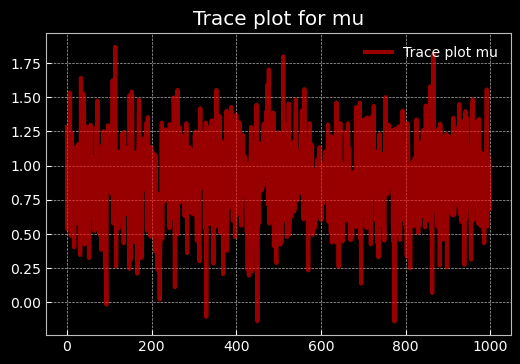

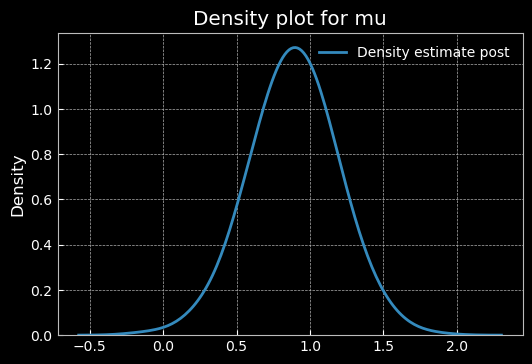

In [7]:
# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(mu_out)), mu_out, 'r-', lw=3, alpha=0.6, label='Trace plot mu') # Trace plot of data
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot for mu')
plt.show()

# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
# plot density estimate of the posterior
sns.kdeplot(np.array(mu_out), bw=0.5, label = 'Density estimate post')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Density plot for mu')
plt.show()

In [8]:
# Summary of sig2
pm.summary(np.array(mu_out))

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.889,0.289,0.411,1.515,0.009,0.007,945.0,945.0,954.0,783.0,NaN


 ### Plotting $\sigma^2$ posterior

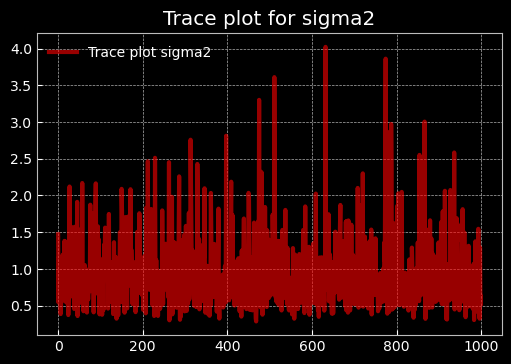

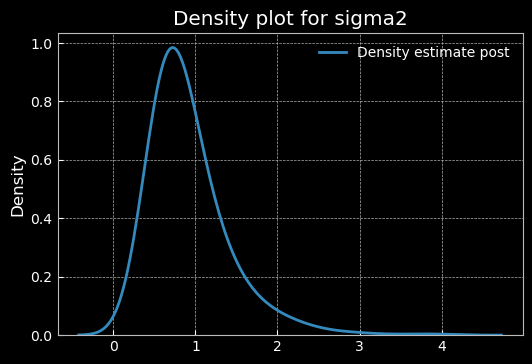

In [9]:
# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(sig2_out)), sig2_out, 'r-', lw=3, alpha=0.6, label='Trace plot sigma2') # Trace plot of data
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot for sigma2')
plt.show()

# Plotting the trace-plot
fig, ax = plt.subplots(1, 1)
# plot density estimate of the posterior
sns.kdeplot(np.array(sig2_out), bw=0.5, label = 'Density estimate post')
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Density plot for sigma2')
plt.show()

In [10]:
# Summary of sig2
pm.summary(np.array(sig2_out))

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.917,0.472,0.299,1.762,0.016,0.011,850.0,850.0,782.0,814.0,NaN


As with the Metropolis-Hastings example, these chains appear to have converged.